Everything on CPU

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization, ELU, LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

from utils import *

import warnings
warnings.filterwarnings("ignore")

In [111]:
tf.__version__

'2.15.0'

In [112]:
tf.random.set_seed(2024)

In [113]:
tukey = pd.read_pickle('data/tukey_estimates.pkl')
excess_returns = pd.read_pickle('data/exc_returns.pkl')
index_returns = pd.read_pickle('data/index_returns.pkl')
stocks_returns = pd.read_pickle('data/stocks_returns.pkl')

In [114]:
LOOK_BACK = 20
n_features = len(tukey.columns)
FORECAST_RANGE = 1

We want to start wit hthe first obsrvation of the actual test set (the whole 2018 year). However our model expect as input the previous 15 observations to perform a prediction. We need to "add" the last 15 observatin of the training set to the testing set.  

In [115]:
starting_date_test = tukey.loc[:'2017-01-02'].index[-(LOOK_BACK+1)]
starting_date_test

Timestamp('2016-12-01 00:00:00')

In [116]:
train_price, test_price = tukey.loc[:'2017-01-02'], tukey.loc[starting_date_test:]

In [117]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_price)
scaled_test = scaler.transform(test_price)

In [118]:
X_train, y_train = split_sequence(scaled_train, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
X_test, y_test = split_sequence(scaled_test, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
print('(Samples, time steps, features)')
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(Samples, time steps, features)
(996, 20, 41)
(996, 1, 41)
(254, 20, 41)
(254, 1, 41)


In [119]:
pd.DataFrame(scaled_train).head(16)

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,0.541517,0.461622,0.034626,0.257120,0.013959,0.100755,0.169548,0.251664,0.429280,0.069447,...,0.016829,0.490880,0.029139,0.324387,0.173636,0.852899,0.899366,0.831756,0.049210,0.067080
1,0.529201,0.461799,0.034262,0.278435,0.003311,0.105064,0.177072,0.242479,0.415421,0.069170,...,0.007411,0.499854,0.019105,0.311892,0.180203,0.844386,0.895234,0.851984,0.042860,0.071488
2,0.516797,0.457860,0.036727,0.296042,0.000000,0.111241,0.184239,0.232479,0.412488,0.061482,...,0.006851,0.517925,0.012021,0.303981,0.189000,0.850401,0.895617,0.872443,0.035237,0.076776
3,0.507911,0.447295,0.034189,0.308523,0.004506,0.120639,0.181054,0.216559,0.409791,0.051458,...,0.000000,0.539547,0.008036,0.297443,0.197833,0.857331,0.891148,0.892111,0.023188,0.088735
4,0.508034,0.438925,0.037815,0.311910,0.032780,0.131367,0.187847,0.208864,0.419323,0.052887,...,0.000213,0.566854,0.008782,0.300046,0.204064,0.877588,0.891316,0.905895,0.018373,0.097186
5,0.511512,0.422013,0.041265,0.309480,0.062710,0.139578,0.178564,0.201452,0.420097,0.056054,...,0.002047,0.569700,0.009469,0.304128,0.211047,0.882571,0.890789,0.912355,0.015429,0.100457
6,0.521391,0.414747,0.040609,0.312093,0.061864,0.144239,0.165171,0.203834,0.430032,0.054294,...,0.004082,0.569046,0.004827,0.296455,0.212109,0.888026,0.879558,0.912538,0.022499,0.095597
7,0.522908,0.406736,0.044093,0.281079,0.061828,0.142693,0.157912,0.216265,0.429174,0.051623,...,0.013135,0.573871,0.000000,0.272436,0.210314,0.894143,0.863180,0.907484,0.033346,0.091237
8,0.526643,0.404740,0.043780,0.278568,0.063943,0.142578,0.153651,0.230493,0.420234,0.050776,...,0.027586,0.576559,0.002892,0.238750,0.206102,0.893838,0.852046,0.902328,0.037035,0.091054
9,0.530767,0.401711,0.042236,0.284384,0.087248,0.146637,0.145950,0.244864,0.413457,0.048868,...,0.039572,0.581729,0.024220,0.222509,0.197721,0.892704,0.842585,0.900060,0.044900,0.087584


In [120]:
y_train[0]

array([[0.5680617 , 0.38422454, 0.0450793 , 0.33356228, 0.31078505,
        0.1376159 , 0.12889475, 0.22681261, 0.39047095, 0.05635801,
        0.13669931, 0.35806766, 0.02131175, 0.07658543, 0.45264635,
        0.12185752, 0.41833921, 0.24220026, 0.07834392, 0.09135701,
        0.07945564, 0.10548382, 0.60299631, 0.09098613, 0.16899732,
        0.15055944, 0.04797331, 0.08593396, 0.353482  , 0.11843276,
        0.1540108 , 0.08714196, 0.48845211, 0.13635028, 0.28273524,
        0.16975447, 0.79518551, 0.71159714, 0.93836774, 0.03296805,
        0.09575853]])

In [121]:
X_train[0]

array([[5.41517497e-01, 4.61622419e-01, 3.46256104e-02, 2.57119733e-01,
        1.39587005e-02, 1.00754654e-01, 1.69547805e-01, 2.51663737e-01,
        4.29279557e-01, 6.94473107e-02, 2.34611053e-01, 3.70297457e-01,
        6.63307122e-02, 1.01872065e-01, 3.91173342e-01, 1.35496571e-01,
        4.08123162e-01, 2.37500855e-01, 1.63170999e-01, 1.17300197e-01,
        7.13347407e-02, 5.41255155e-02, 6.56006825e-01, 6.92384440e-02,
        1.95977993e-01, 1.17170024e-01, 8.86390227e-02, 1.56268167e-01,
        2.09577475e-01, 1.72731754e-01, 3.18454540e-01, 1.68289004e-02,
        4.90879943e-01, 2.91390213e-02, 3.24387023e-01, 1.73635728e-01,
        8.52898807e-01, 8.99365736e-01, 8.31755515e-01, 4.92100648e-02,
        6.70798906e-02],
       [5.29200994e-01, 4.61798844e-01, 3.42617711e-02, 2.78435479e-01,
        3.31113585e-03, 1.05064495e-01, 1.77071786e-01, 2.42479285e-01,
        4.15420725e-01, 6.91696514e-02, 2.15920869e-01, 3.64839847e-01,
        6.54307025e-02, 9.24787579e-02,

In [122]:
X_train.shape

(996, 20, 41)

Everything matches. Each row of my dataset is an element of the arrays: 1001 samples where each sample has 15 timesteps for each of the 41 stocks. The sequences are ready for training.

### Functions

In [123]:
def inverse_transform(y_test, yhat):
    y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])
    yhat_reshaped = yhat.reshape(-1, yhat.shape[-1])
    yhat_inverse = scaler.inverse_transform(yhat_reshaped)
    y_test_inverse = scaler.inverse_transform(y_test_reshaped)
    return yhat_inverse, y_test_inverse


def evaluate_forecast(y_test_inverse, yhat_inverse):
    mse_ = tf.keras.losses.MeanSquaredError()
    mae_ = tf.keras.losses.MeanAbsoluteError()
    mape_ = tf.keras.losses.MeanAbsolutePercentageError()
    mae = mae_(y_test_inverse,yhat_inverse)
    print('mae:', mae.numpy())
    mse = mse_(y_test_inverse,yhat_inverse)
    print('mse:', mse.numpy())
    mape = mape_(y_test_inverse,yhat_inverse)
    print('mape:', mape.numpy())

def calculate_metrics(y_test_inverse, yhat_inverse, tukey):
    metrics_df = pd.DataFrame(columns=['Stock', 'MAE', 'MSE', 'MAPE'])
    mse_ = tf.keras.losses.MeanSquaredError()
    mae_ = tf.keras.losses.MeanAbsoluteError()
    mape_ = tf.keras.losses.MeanAbsolutePercentageError()

    for stock in range(y_test_inverse.shape[1]):
        stock_name = tukey.iloc[:, stock].name
        mae = mae_(y_test_inverse[:, stock], yhat_inverse[:, stock])
        mse = mse_(y_test_inverse[:, stock], yhat_inverse[:, stock])
        mape = mape_(y_test_inverse[:, stock], yhat_inverse[:, stock])

        metrics_df = metrics_df.append({'Stock': stock_name, 'MAE': mae.numpy(), 'MSE': mse.numpy(), 'MAPE': mape.numpy()}, ignore_index=True)
    
    return metrics_df

## Sequence-2-Sequence Modeling (many-to-many) with LSTMs:
Using encoder-decoder architectures to forecast multiple time series with one model. The encoder is basically responsible for reading and interpreting the input. The encoder part compresses the input into a small representation (a fixed-length vector) of the original input, and this "context vector" is given to the decoder part as input to be interpreted and perform forecasting.
- RepeatVector layer is used to repeat N times the context vector we obtain from the encoder part. N is the number of future steps you want to forecast and is fed into the decoder part.
- A fully connected Dense layer is applied to each time step via TimeDistributed wrapper, so separates the output for each time step. The TimeDistributed allows to treat independently each time series.

### LSTM

In [124]:
model_enc_dec = Sequential()
model_enc_dec.add(LSTM(100, activation='relu', input_shape=(LOOK_BACK, n_features)))
model_enc_dec.add(RepeatVector(FORECAST_RANGE))
model_enc_dec.add(LSTM(100, activation='relu', return_sequences=True))
model_enc_dec.add(TimeDistributed(Dense(n_features)))
model_enc_dec.compile(optimizer='adam', loss='mse')

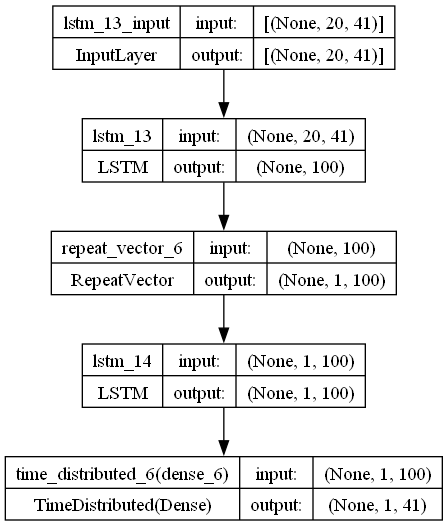

In [125]:
plot_model(model=model_enc_dec, show_shapes=True)

In [126]:
history = model_enc_dec.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50


32/32 [==============================] - 4s 13ms/step - loss: 0.1511
Epoch 2/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0350
Epoch 3/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0165
Epoch 4/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0104
Epoch 5/50
32/32 [==============================] - 0s 16ms/step - loss: 0.0081
Epoch 6/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0067
Epoch 7/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0056
Epoch 8/50
32/32 [==============================] - 0s 12ms/step - loss: 0.0046
Epoch 9/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0039
Epoch 10/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0036
Epoch 11/50
32/32 [==============================] - 0s 12ms/step - loss: 0.0033
Epoch 12/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0030
Epoch 13/50
32/32 [=============================

In [127]:
yhat = model_enc_dec.predict(X_test, verbose=0)

In [128]:
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)

In [129]:
evaluate_forecast(y_test_inverse, yhat_inverse)

mae: 4.644852
mse: 52.870327
mape: 8.505311


In [130]:
yhat_inverse.shape, y_test_inverse.shape

((254, 41), (254, 41))

In [131]:
metrics_df = pd.DataFrame(columns=['Stock', 'MAE', 'MSE', 'MAPE'])
mse_ = tf.keras.losses.MeanSquaredError()
mae_ = tf.keras.losses.MeanAbsoluteError()
mape_ = tf.keras.losses.MeanAbsolutePercentageError()

for stock in range(y_test_inverse.shape[1]):
    stock_name = tukey.iloc[:, stock].name
    mae = mae_(y_test_inverse[:, stock], yhat_inverse[:, stock])
    mse = mse_(y_test_inverse[:, stock], yhat_inverse[:, stock])
    mape = mape_(y_test_inverse[:, stock], yhat_inverse[:, stock])

    metrics_df = metrics_df.append({'Stock': stock_name, 'MAE': mae.numpy(), 'MSE': mse.numpy(), 'MAPE': mape.numpy()}, ignore_index=True)

In [132]:
metrics_df = calculate_metrics(y_test_inverse, yhat_inverse, tukey)
metrics_df

,Stock,MAE,MSE,MAPE
0,VOW3 GY Equity,8.731339,148.791412,6.838181
1,ENGI FP Equity,1.222947,1.889974,8.846251
2,BAYN GY Equity,9.386862,98.263283,8.584463
3,BNP FP Equity,6.130383,45.419262,9.666808
4,PHIA NA Equity,1.511859,2.906416,5.211202
5,ISP IM Equity,0.173504,0.049283,6.383839
6,SAN FP Equity,4.260252,26.765179,5.111887
7,MC FP Equity,20.049383,493.900085,8.795096
8,ENEL IM Equity,0.362690,0.211764,7.219990
9,CS FP Equity,2.262695,5.854699,9.270833


In [133]:
yhat_inverse_df = pd.DataFrame(yhat_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)
y_test_inverse_df = pd.DataFrame(y_test_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)

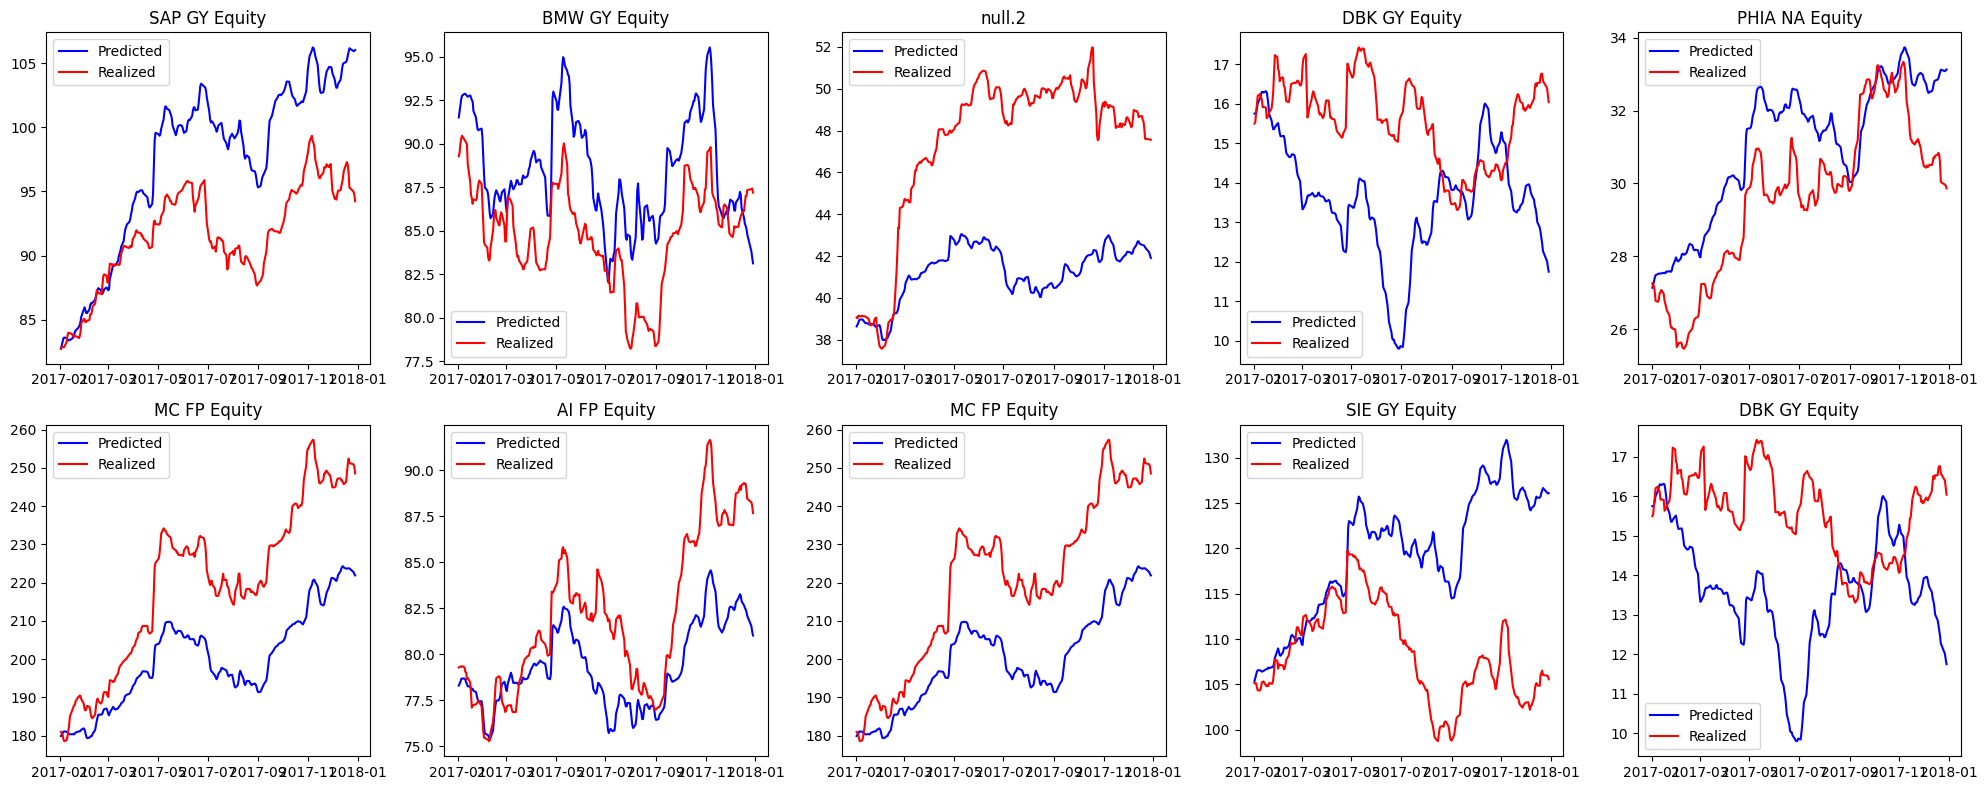

In [134]:
rand = np.random.randint(0, 41, 10)
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

for i, stock in enumerate(rand):
    row = i // 5
    col = i % 5
    axs[row, col].plot(yhat_inverse_df.iloc[:, stock], color='blue', label='Predicted')
    axs[row, col].plot(y_test_inverse_df.iloc[:, stock], color='red', label='Realized')
    axs[row, col].legend()
    axs[row, col].set_title(yhat_inverse_df.iloc[:, stock].name)

plt.tight_layout()
plt.show()

### CNN-LSTM

In [135]:
cnn_lstm = Sequential()
cnn_lstm.add(Conv1D(filters=64, kernel_size=9, activation='relu', input_shape=(LOOK_BACK, n_features)))
cnn_lstm.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
cnn_lstm.add(MaxPooling1D(pool_size=2))
cnn_lstm.add(Flatten())
cnn_lstm.add(RepeatVector(FORECAST_RANGE))
cnn_lstm.add(LSTM(200, activation='relu', return_sequences=True))
cnn_lstm.add(TimeDistributed(Dense(100, activation='relu')))
cnn_lstm.add(TimeDistributed(Dense(n_features)))
cnn_lstm.compile(loss='mse', optimizer='adam')

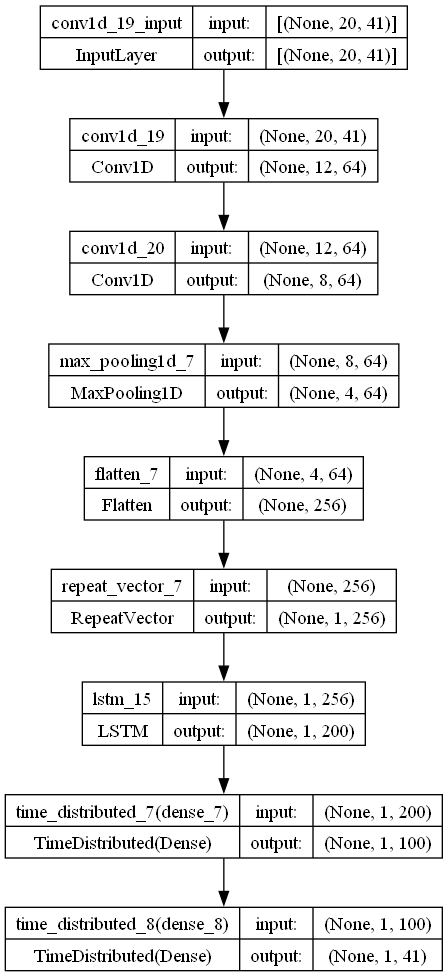

In [136]:
plot_model(model=cnn_lstm, show_shapes=True)

In [137]:
history = cnn_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50


32/32 [==============================] - 2s 6ms/step - loss: 0.0899
Epoch 2/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0220
Epoch 3/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0136
Epoch 4/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0109
Epoch 5/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0090
Epoch 6/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0077
Epoch 7/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0065
Epoch 8/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0064
Epoch 9/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0056
Epoch 10/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0049
Epoch 11/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0049
Epoch 12/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0043
Epoch 13/50
32/32 [==============================] - 0s 6ms/

In [138]:
yhat = cnn_lstm.predict(X_test, verbose=0)

In [139]:
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)

In [140]:
evaluate_forecast(y_test_inverse, yhat_inverse)

mae: 4.245602
mse: 64.47923
mape: 7.138687


In [141]:
yhat_inverse.shape, y_test_inverse.shape

((254, 41), (254, 41))

In [142]:
metrics_df = calculate_metrics(y_test_inverse, yhat_inverse, tukey)
metrics_df

,Stock,MAE,MSE,MAPE
0,VOW3 GY Equity,5.632229,50.370712,4.465024
1,ENGI FP Equity,1.384504,2.519722,10.059124
2,BAYN GY Equity,10.451077,143.484528,9.488441
3,BNP FP Equity,2.186624,6.933799,3.526535
4,PHIA NA Equity,1.868011,5.048231,6.077321
5,ISP IM Equity,0.289844,0.104769,10.495327
6,SAN FP Equity,5.286993,39.692444,6.317725
7,MC FP Equity,29.356524,1126.157959,12.769892
8,ENEL IM Equity,0.499826,0.366246,9.940548
9,CS FP Equity,0.899386,1.192096,3.741711


In [143]:
yhat_inverse_df = pd.DataFrame(yhat_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)
y_test_inverse_df = pd.DataFrame(y_test_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)

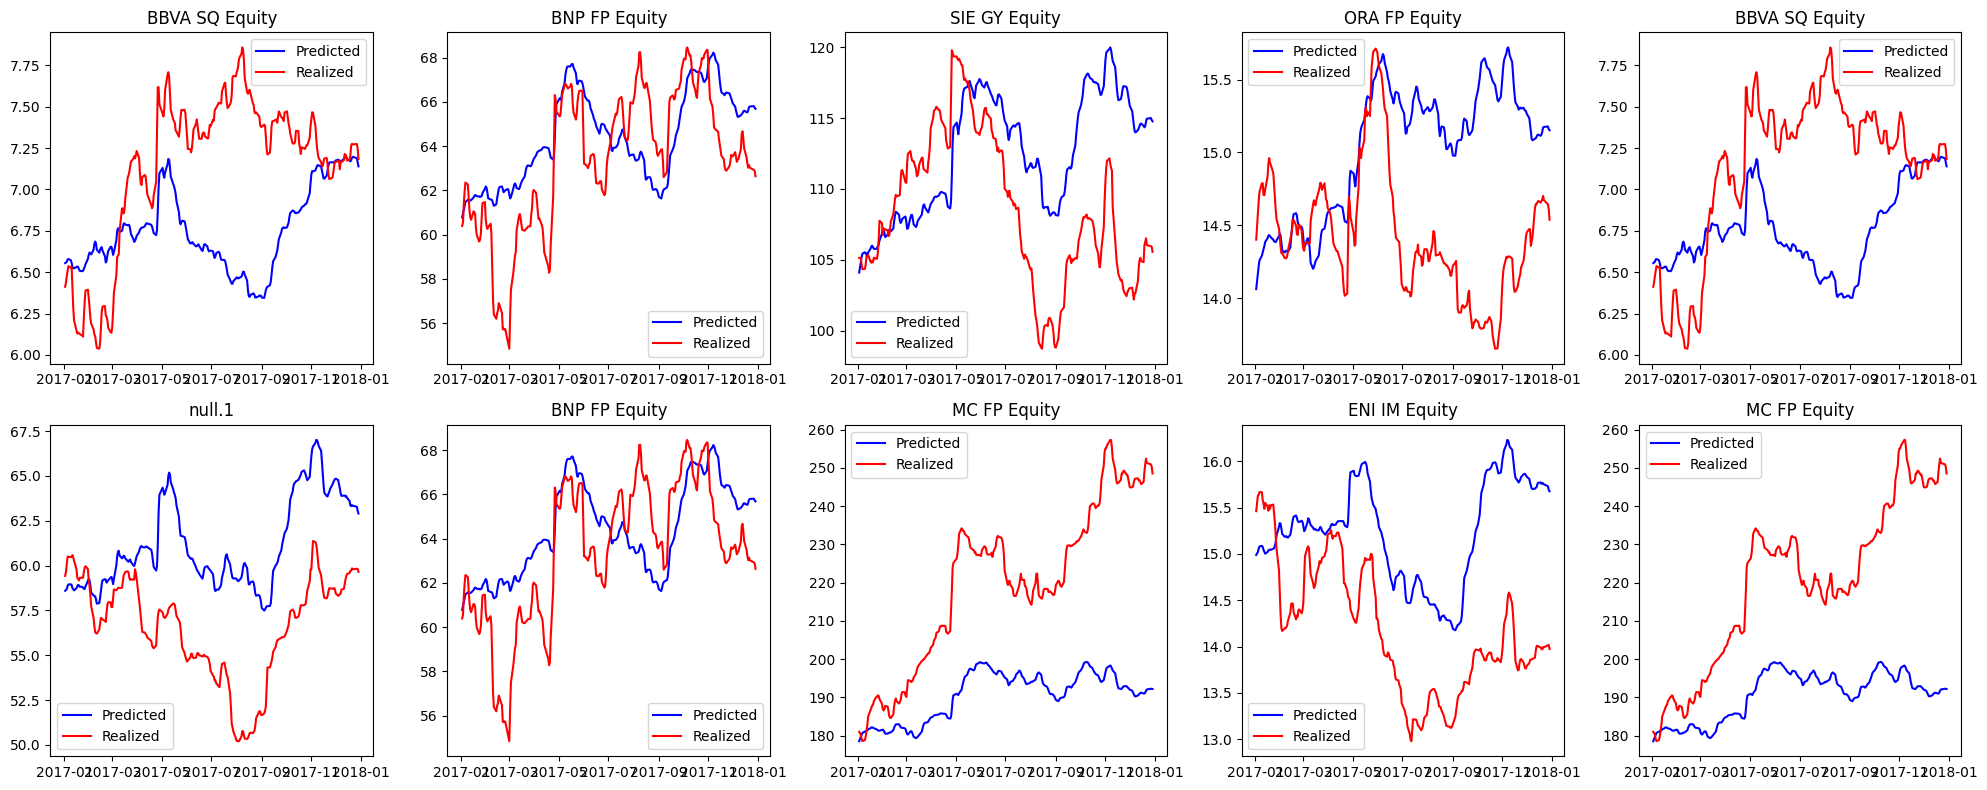

In [144]:
rand = np.random.randint(0, 41, 10)
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

for i, stock in enumerate(rand):
    row = i // 5
    col = i % 5
    axs[row, col].plot(yhat_inverse_df.iloc[:, stock], color='blue', label='Predicted')
    axs[row, col].plot(y_test_inverse_df.iloc[:, stock], color='red', label='Realized')
    axs[row, col].legend()
    axs[row, col].set_title(yhat_inverse_df.iloc[:, stock].name)

plt.tight_layout()
plt.show()

### Multi-Head CNN-LSTM

The multi-head structure uses multiple one-dimensional CNN layers in order to process each time series and extract independent convolved features from each time series. These separate CNNs are called “head” and flattened, concatenated, and reshaped respectively before feeding into the LSTM layer. Therefore, they might be more successful to keep significant features of each time series and make better forecasts in this sense.

In [156]:
input_layer = Input(shape=(LOOK_BACK, n_features)) 
head_list = []
# 41 "heads", each to extract feats from each ts :)
for i in range(0, n_features):
    conv_layer_head = Conv1D(filters=4, kernel_size=7, activation='relu')(input_layer)
    conv_layer_head_2 = Conv1D(filters=6, kernel_size=5, activation='relu')(conv_layer_head)
    conv_layer_flatten = Flatten()(conv_layer_head_2)
    head_list.append(conv_layer_flatten)
 
concat_cnn = Concatenate(axis=1)(head_list)
reshape = Reshape((head_list[0].shape[1], n_features))(concat_cnn)
lstm = LSTM(100, activation='relu')(reshape)
repeat = RepeatVector(FORECAST_RANGE)(lstm)
lstm_2 = LSTM(100, activation='relu', return_sequences=True)(repeat)
dropout = Dropout(0.2)(lstm_2)
dense = Dense(n_features, activation='linear')(dropout)
multi_head_cnn_lstm_model = Model(inputs=input_layer, outputs=dense)

multi_head_cnn_lstm_model.compile(loss='mse', optimizer='adam')

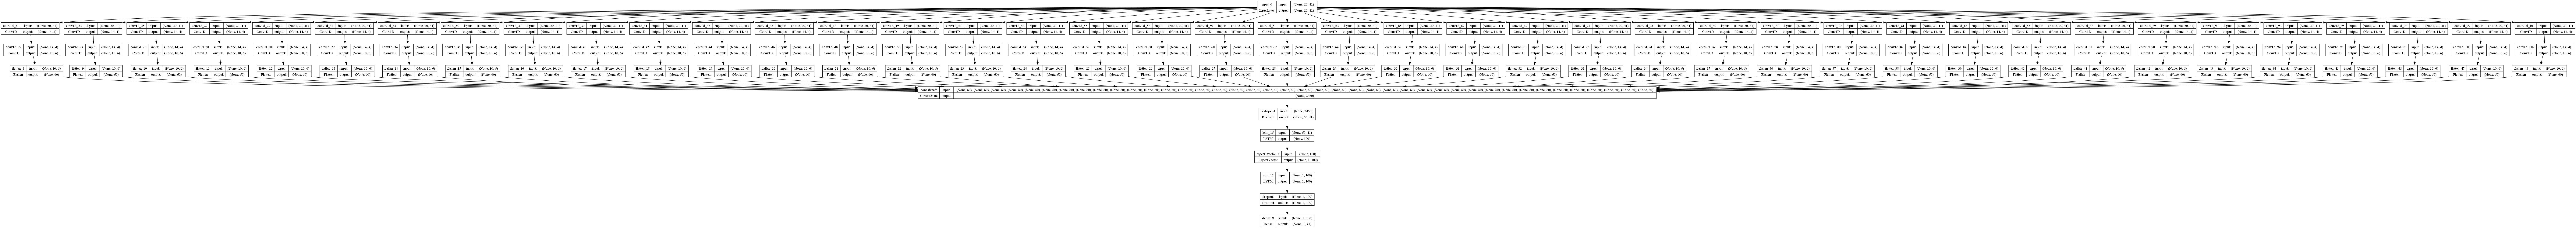

In [146]:
plot_model(model=multi_head_cnn_lstm_model, show_shapes=True)

In [157]:
history = multi_head_cnn_lstm_model.fit(X_train, y_train, epochs=70, batch_size=32)
# 70 epochs to reach global minimum

Epoch 1/100


32/32 [==============================] - 20s 37ms/step - loss: 0.1962
Epoch 2/100
32/32 [==============================] - 1s 39ms/step - loss: 0.0610
Epoch 3/100
32/32 [==============================] - 1s 36ms/step - loss: 0.0508
Epoch 4/100
32/32 [==============================] - 1s 37ms/step - loss: 0.0448
Epoch 5/100
32/32 [==============================] - 1s 37ms/step - loss: 0.0308
Epoch 6/100
32/32 [==============================] - 1s 38ms/step - loss: 0.0247
Epoch 7/100
32/32 [==============================] - 1s 37ms/step - loss: 0.0222
Epoch 8/100
32/32 [==============================] - 1s 35ms/step - loss: 0.0205
Epoch 9/100
32/32 [==============================] - 1s 36ms/step - loss: 0.0191
Epoch 10/100
32/32 [==============================] - 1s 35ms/step - loss: 0.0182
Epoch 11/100
32/32 [==============================] - 1s 35ms/step - loss: 0.0175
Epoch 12/100
32/32 [==============================] - 1s 37ms/step - loss: 0.0167
Epoch 13/100
32/32 [================

In [158]:
yhat = multi_head_cnn_lstm_model.predict(X_test, verbose=0)

In [159]:
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)

In [160]:
evaluate_forecast(y_test_inverse, yhat_inverse)

mae: 4.7474003
mse: 59.751545
mape: 8.683118


In [161]:
metrics_df = calculate_metrics(y_test_inverse, yhat_inverse, tukey)
metrics_df

,Stock,MAE,MSE,MAPE
0,VOW3 GY Equity,11.757830,226.360657,9.127668
1,ENGI FP Equity,2.217265,6.144761,15.955758
2,BAYN GY Equity,12.606238,181.742416,11.480854
3,BNP FP Equity,4.912844,30.374853,7.819222
4,PHIA NA Equity,1.106201,1.797038,3.777446
5,ISP IM Equity,0.257165,0.093597,9.334076
6,SAN FP Equity,5.503752,40.529572,6.589226
7,MC FP Equity,20.937590,617.159790,9.045817
8,ENEL IM Equity,0.384262,0.208748,7.773196
9,CS FP Equity,1.399359,2.594346,5.776369


In [162]:
yhat_inverse_df = pd.DataFrame(yhat_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)
y_test_inverse_df = pd.DataFrame(y_test_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)

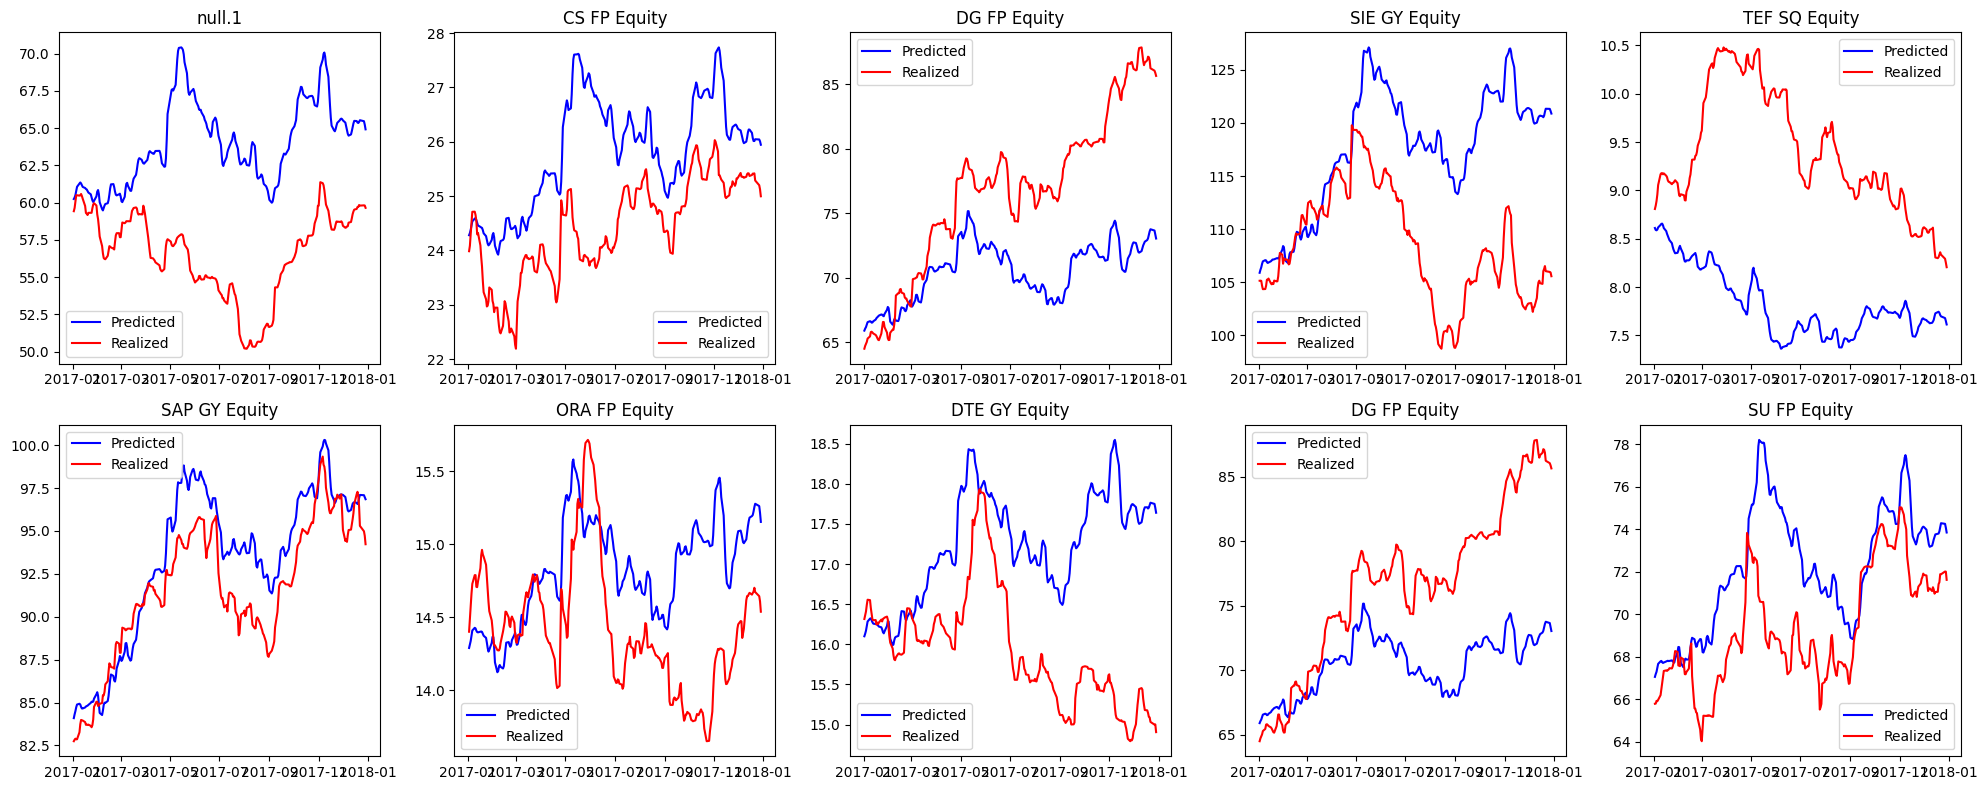

In [163]:
rand = np.random.randint(0, 41, 10)
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

for i, stock in enumerate(rand):
    row = i // 5
    col = i % 5
    axs[row, col].plot(yhat_inverse_df.iloc[:, stock], color='blue', label='Predicted')
    axs[row, col].plot(y_test_inverse_df.iloc[:, stock], color='red', label='Realized')
    axs[row, col].legend()
    axs[row, col].set_title(yhat_inverse_df.iloc[:, stock].name)

plt.tight_layout()
plt.show()

### CNN-BiLSTM

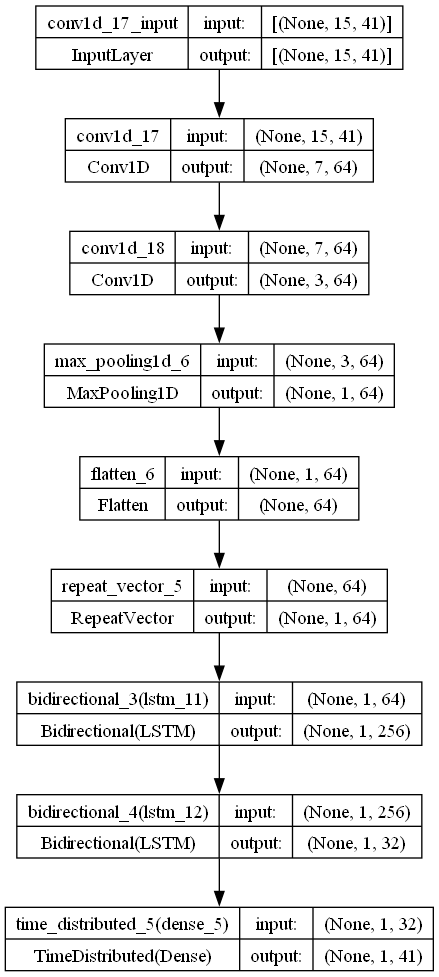

In [154]:
plot_model(model=cnn_bilstm, show_shapes=True)

In [155]:
history = cnn_bilstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50


InvalidArgumentError: Graph execution error:

Detected at node while_20/body/_1/while/MatMul defined at (most recent call last):
<stack traces unavailable>
Matrix size-incompatible: In[0]: [32,256], In[1]: [64,512]
	 [[{{node while_20/body/_1/while/MatMul}}]]
	 [[sequential_5/bidirectional_3/forward_lstm_11/PartitionedCall]] [Op:__inference_train_function_115455]

In [ ]:
yhat = cnn_bilstm.predict(X_test, verbose=0)

In [ ]:
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)

In [ ]:
evaluate_forecast(y_test_inverse, yhat_inverse)

In [ ]:
metrics_df = calculate_metrics(y_test_inverse, yhat_inverse, tukey)
metrics_df

In [ ]:
yhat_inverse_df = pd.DataFrame(yhat_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)
y_test_inverse_df = pd.DataFrame(y_test_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)

In [ ]:
rand = np.random.randint(0, 41, 10)
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

for i, stock in enumerate(rand):
    row = i // 5
    col = i % 5
    axs[row, col].plot(yhat_inverse_df.iloc[:, stock], color='blue', label='Predicted')
    axs[row, col].plot(y_test_inverse_df.iloc[:, stock], color='red', label='Realized')
    axs[row, col].legend()
    axs[row, col].set_title(yhat_inverse_df.iloc[:, stock].name)

plt.tight_layout()
plt.show()

#### Could save the predictions of the model(s) in a pickle file and load them on an ptf_optimization.ipynb notebook

----------------

### DO NOT CONSIDER CODE BELOW

In [ ]:
portfolios_LSTM = get_ranking(yhat_inverse, N = [5, 7, 10], prices=True)
 
tot_performance_LSTM, portfolio_series_LSTM = calc_portfolios(portfolios_LSTM, stocks_returns.loc[yhat_inverse.index[0]:])


tot_performance_LSTM['Index performance'] = (1 + index_returns.loc[yhat_inverse.index[0]:]).prod() - 1 
tot_performance_LSTM

NameError: name 'get_ranking' is not defined

In [ ]:
# TOP 5 PORTFOLIO (best one in terms of cumulative return)
# mean returns, mean std and sharpe ratio (hyp : zero risk free rate)
portfolio_series_LSTM['Top5 series'].mean(), portfolio_series_LSTM['Top5 series'].std(), portfolio_series_LSTM['Top5 series'].mean()/portfolio_series_LSTM['Top5 series'].std() * 100

(0.002940179023940558, 0.0537965213225773, 5.465370160852064)

In [ ]:
# INDEX 
# mean returns, mean std and sharpe ratio (hyp : zero risk free rate)

index_returns.loc[yhat_inverse.index[0]:].mean(), index_returns.loc[yhat_inverse.index[0]:].std(), index_returns.loc[yhat_inverse.index[0]:].mean()/index_returns.loc[yhat_inverse.index[0]:].std() * 100

(0.0003492689328041595, 0.00626025876636661, 5.5791453011593575)

In [ ]:
plot_portfolios(portfolio_series_LSTM, index_returns.loc[yhat_inverse.index[0]:])

--------------